In [1]:
import json
import math
import itertools
from collections import defaultdict
import numpy as np
from scipy.stats import spearmanr, shapiro, mannwhitneyu
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Build graph

In [20]:
# Load data
artists_dict = json.load(open("data/artists_10k.json", "r"))
related_dict = json.load(open("data/related_10k.json", "r"))

In [21]:
# Build graph
G = nx.Graph()
for artist, related in related_dict.items():
    for next_artist in related:
        G.add_edge(artist, next_artist)

In [22]:
# Print basic graph properties
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("Connected components: ", nx.number_connected_components(G))
print("Average clustering coefficient: ", nx.average_clustering(G))

Number of nodes:  10005
Number of edges:  53284
Connected components:  1
Average clustering coefficient:  0.3649781995725766


## Centrality Measures

In [28]:
# Compute betweenness centrality
between = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)
eigen = nx.eigenvector_centrality_numpy(G)

In [29]:
# Compute correlation between centralities and followers
followers = []
between_centrals = []
close_centrals = []
eigen_centrals = []
for artist in between:
    followers.append(artists_dict[artist]["followers"])
    between_centrals.append(between[artist])
    close_centrals.append(close[artist])
    eigen_centrals.append(eigen[artist])

In [30]:
stat, p = shapiro(followers)
print(stat, p)

0.15867626667022705 0.0


/Users/jdeitel/Documents/related_artists/387_env/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [31]:
# Correlation of betweenness and followers
corr, p = spearmanr(followers, between_centrals)
print(corr, p)

0.3894730376900569 0.0


In [32]:
# Correlation of closeness and followers
corr, p = spearmanr(followers, close_centrals)
print(corr, p)

0.412942507516997 0.0


In [33]:
# Correlation of closeness and followers
corr, p = spearmanr(followers, eigen_centrals)
print(corr, p)

0.2647610769671224 4.130486407696351e-160


## Partitioning

In [23]:
# Number of clusters to analyze
num_clusters = 30

In [10]:
# Partition graph
def partition(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [13]:
# Get graph partitions via Girvan-Newman
%time communities = partition(num_clusters, G)

CPU times: user 1h 41min 1s, sys: 10.2 s, total: 1h 41min 11s
Wall time: 1h 41min 20s


In [14]:
# Compute inverse document frequencies
idf = defaultdict(int)
for partition in communities:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

In [34]:
# Get most common genre in partition
def get_name(node_list):
    counts = defaultdict(int)
    for node in node_list:
        genres = artists_dict[node]["genres"]
        for genre in genres:
            counts[genre.replace(" ", "_")] += 1
    tf_idf = {k: v * idf[k] for k, v in counts.items()}
    return max(tf_idf, key=tf_idf.get)

In [38]:
# Get center of each partition
labels = {}
cluster_labels = []
for community in communities:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    cluster_labels.append(name)
    print(artists_dict[center]["name"], name)

88GLAM trap
Christian French pop edm
Meek Mill southern hip hop
Meghan Trainor post-teen pop
Duckwrth underground hip hop
Kelly Rowland r&b
Canaan Smith contemporary country
Asian Doll trap queen
Steel Banglez uk hip hop
Panic! At The Disco pop punk
Rich Brian k-hop
Becky G latin
MAGIC! jawaiian
Josh X deep pop r&b
Lotto Boyzz uk hip hop


In [17]:
# Generate colors and labels for graph
colors = []
for node in G.nodes():
    for i in range(len(communities)):
        if node in communities[i]:
            colors.append(i)

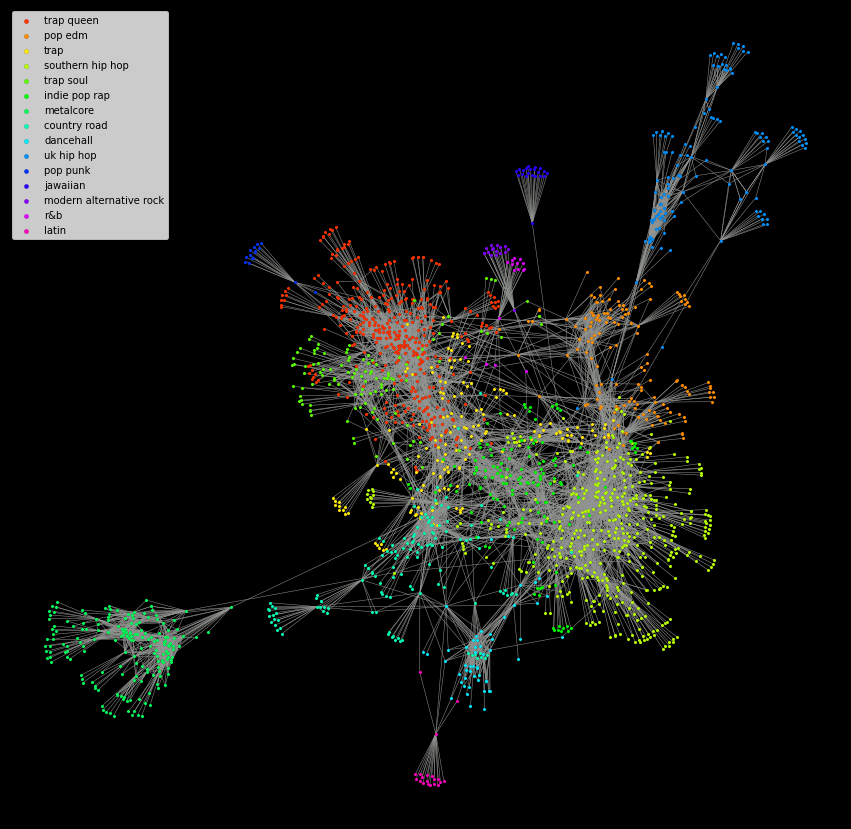

In [83]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(communities)+1)
color_map = rainbow(range(len(communities)+1))
pos=nx.spring_layout(G)
for i, cluster in enumerate(communities):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

## Spectral Clustering

### Many clusters

In [24]:
# Get clusters via spectral clustering
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(num_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')
%time sc.fit(adj_mat)

CPU times: user 1min 22s, sys: 9.31 s, total: 1min 31s
Wall time: 29.1 s


SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=30, n_components=None,
                   n_init=100, n_jobs=None, n_neighbors=10, random_state=None)

In [18]:
import pickle
communities = pickle.load(open("2k_communities.p", "rb"))
# Generate colors and labels for graph
colors = []
for node in G.nodes():
    for i in range(len(communities)):
        if node in communities[i]:
            colors.append(i)

In [19]:
# Compute similarity between clusterings
print(metrics.adjusted_rand_score(colors, sc.labels_))
print(metrics.adjusted_mutual_info_score(colors, sc.labels_))

0.6591899350773845
0.8137156630990027


In [25]:
# Get clusters by ids
clusters = []
for i in range(num_clusters):
    cur_cluster = []
    for j, artist in enumerate(G.nodes):
        if sc.labels_[j] == i:
            cur_cluster.append(artist)
    clusters.append(cur_cluster)

In [26]:
# Compute inverse document frequencies for clusters
idf = defaultdict(int)
for partition in clusters:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(clusters)/v) for k, v in idf.items()}

In [35]:
# Get center of each cluster
labels = {}
cluster_labels = []
for community in clusters:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    cluster_labels.append(name)
    print(artists_dict[center]["name"], name)

Problem west coast trap
Pia Mia post-teen pop
Nitti Gritti brostep
Weathers modern alternative rock
Chelly the MC christian trap
The Homeless Gospel Choir folk punk
Becky G latin
The Sunny Cowgirls australian country
Kelvyn Colt german hip hop
Destroy Boys riot grrrl
John Adorney new age
Nesian N.I.N.E. jawaiian
Slaughter Beach, Dog indie rock
Tion Wayne uk hip hop
Rich Brian indonesian indie
NateWantsToBattle otacore
Goldfinger skate punk
Ledri Vula albanian pop
You Me At Six screamo
David Nail country road
Lauren Jauregui baile pop
Slim Dinero canadian hip hop
DING DONG dancehall
Warhol.SS vapor trap
Busta Rhymes hip hop
Mindless Self Indulgence industrial metal
Belly hip hop quebecois
Smithfield country pop
Pistol Pete & Enzo aussie drill
Ajebutter22 nigerian pop


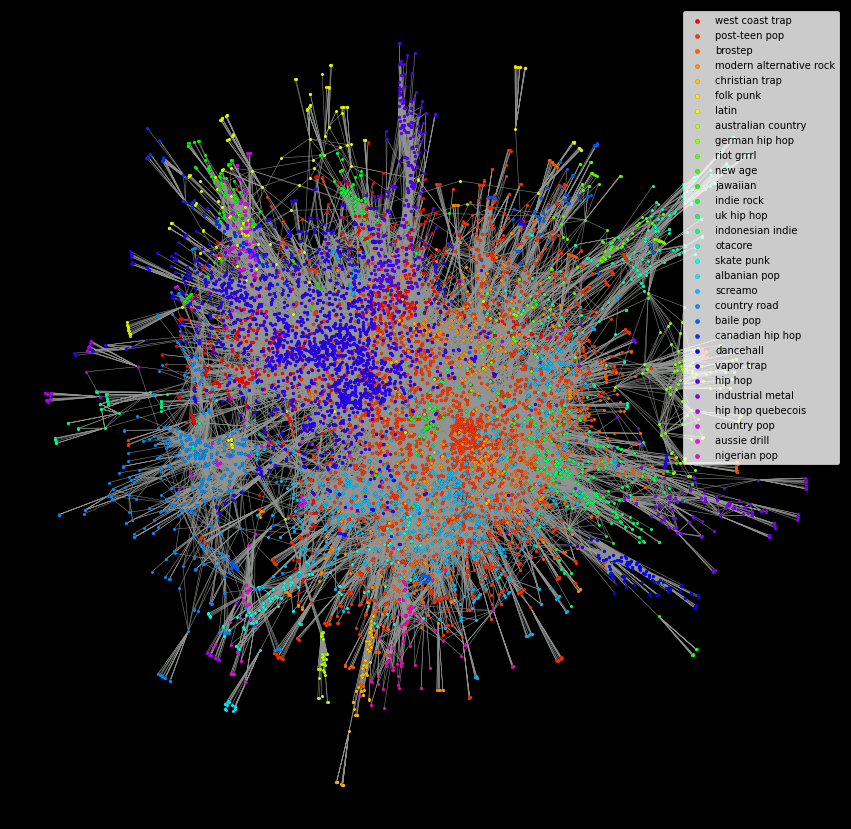

In [36]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(clusters)+1)
color_map = rainbow(range(len(clusters)+1))
pos=nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

### Less clusters

In [37]:
# Get clusters via spectral clustering
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
%time sc.fit(adj_mat)

CPU times: user 1min 9s, sys: 8.47 s, total: 1min 17s
Wall time: 26.2 s


SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=100, n_jobs=None, n_neighbors=10, random_state=None)

In [38]:
# Get clusters by ids
clusters = []
for i in range(5):
    cur_cluster = []
    for j, artist in enumerate(G.nodes):
        if sc.labels_[j] == i:
            cur_cluster.append(artist)
    clusters.append(cur_cluster)

In [39]:
# Compute inverse document frequencies for clusters
idf = defaultdict(int)
for partition in clusters:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(clusters)/v) for k, v in idf.items()}

In [40]:
# Get center of each cluster
labels = {}
cluster_labels = []
for community in clusters:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    cluster_labels.append(name)
    print(artists_dict[center]["name"], name)

24hrs rap
Spawnbreezie polynesian pop
Gabbie Hanna pop punk
Craig Campbell country pop
Kelvyn Colt german hip hop


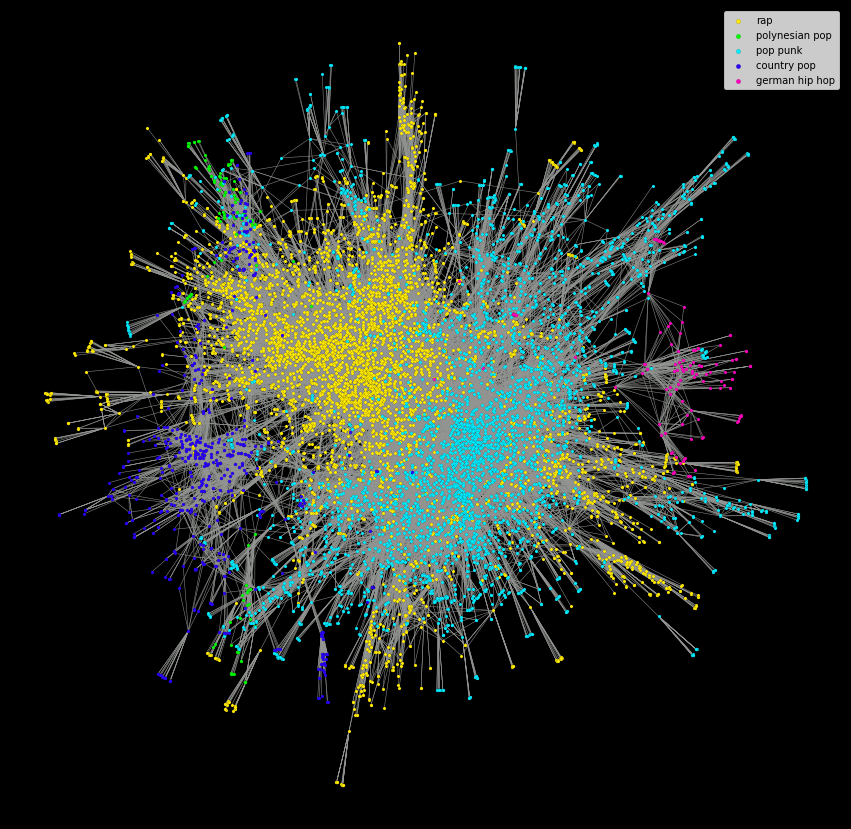

In [41]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(clusters)+1)
color_map = rainbow(range(len(clusters)+1))
#pos=nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

## Bridges

In [42]:
center_nodes = [node for node in G.nodes() if G.degree[node] >= 20]
print(len(center_nodes))

3292


In [43]:
cross_count = defaultdict(int)
for edge in G.edges():
    left = sc.labels_[list(G.nodes()).index(edge[0])]
    right = sc.labels_[list(G.nodes()).index(edge[1])]
    if left != right:
        cross_count[edge[0]] += 1
        cross_count[edge[1]] += 1

In [44]:
crossing_followers = []
other_followers = []
crossing_genres = []
other_genres = []
for artist in center_nodes:
    if cross_count[artist] > 0:
        crossing_followers.append(artists_dict[artist]["followers"])
        crossing_genres.append(len(artists_dict[artist]["genres"]))
    else:
        other_followers.append(artists_dict[artist]["followers"])
        other_genres.append(len(artists_dict[artist]["genres"]))

In [45]:
# Do cross nodes have more followers?
print(mannwhitneyu(crossing_followers, other_followers))
print(np.mean(crossing_followers))
print(np.mean(other_followers))

MannwhitneyuResult(statistic=603985.0, pvalue=2.260346106419621e-11)
1152689.7059925094
582955.0968092821


In [46]:
# Do cross nodes list more genres?
print(mannwhitneyu(crossing_genres, other_genres))
print(np.mean(crossing_genres))
print(np.mean(other_genres))

MannwhitneyuResult(statistic=672544.5, pvalue=0.0006694936043617098)
3.9887640449438204
3.569253081943437


In [47]:
# Correlation between number of crosses and followers
followers = []
num_crosses = []
for artist in center_nodes:
    followers.append(artists_dict[artist]["followers"])
    num_crosses.append(cross_count[artist])

In [48]:
print(spearmanr(num_crosses, followers))

SpearmanrResult(correlation=0.11755458903933765, pvalue=1.3265282379279651e-11)
